In [13]:
import numpy as np
import keras.applications
from keras.applications.resnet50 import preprocess_input as p_i, decode_predictions, ResNet50
from keras.preprocessing import image
import h5py
from keras.activations import softmax, relu, sigmoid
#from keras.applications.vgg19 import VGG19
#from keras.applications.vgg19 import preprocess_input
import h5py
from PIL import Image
import gdal
import keras.backend as K
from keras.layers import Dense, Input, Conv2D, Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers.core import Dropout, Activation
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.models import Model, Sequential
from skimage.transform import resize
import tensorflow as tf

In [14]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

In [ ]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
config.gpu_options.allow_growth = True


In [16]:
def create_model(input_shape, top='flatten'):
    if top not in ('flatten', 'avg', 'max'):
        raise ValueError('unexpected top layer type: %s' % top)
    BottleneckLayer = {
        'flatten': Flatten(),
        'avg': GlobalAveragePooling2D(),
        'max': GlobalMaxPooling2D()
    }[top]
    base = ResNet50(input_shape=input_shape, include_top=False, weights=None)
    x = BottleneckLayer(base.output)
    x = Dense(1, activation='linear')(x)
    model = Model(inputs=base.inputs, outputs=x)
    return model
model = create_model((222, 222, 3))

In [18]:
s = Sequential()
s.add(Conv2D(3, 5, strides=(4, 4)))
s.build()
s.compile(optimizer='sgd', loss='mse')

In [ ]:


s.fit(np.ones((1, 889, 889, 3)), np.zeros((1,222,222,3)))
print("done fitting")
s.summary()

Epoch 1/1


In [47]:
X = np.load("X_889.npy")
y = np.load("y2.npy")

In [48]:
X = X[:,:,:,:3]
X[:1].shape

(1, 889, 889, 3)

In [ ]:
def create_model(input_shape, top='flatten'):
    if top not in ('flatten', 'avg', 'max'):
        raise ValueError('unexpected top layer type: %s' % top)

    # connects base model with new "head"
    BottleneckLayer = {
        'flatten': Flatten(),
        'avg': GlobalAveragePooling2D(),
        'max': GlobalMaxPooling2D()
    }[top]

    base = ResNet50(input_shape=input_shape,
                             include_top=False, 
                             weights='imagenet')
    print("here")
    #base.load_weights("imnet.hdf5")
    #print("weights done")
    x = BottleneckLayer(base.output)
    x = Dense(1, activation='linear')(x)
    model = Model(inputs=base.inputs, outputs=x)
    return model

In [36]:
model.save_weights("imnet.hdf5")

In [338]:
def im_to_arr(path):
    ds = gdal.Open(path)
    arr = np.nan_to_num(ds.ReadAsArray())
    return arr
def im_to_arr_resize(path, size=224):
    arr = im_to_arr(path)
    m = np.min(arr)
    ma = np.max(arr)
    arr[0] = (arr[0] - m) / ma
    arr[1] = (arr[1] - m) / ma
    arr[2] = (arr[2] - m) / ma
    arr = resize(arr, (3, 224, 224))
    #img = img.resize((size, size))
    #arr = np.array(img)
    return arr

In [17]:
#preprocessing
img_path = '/Users/catherinecang/Downloads/ES705_2005 (5).tif'
im = im_to_arr(img_path).astype(np.uint8)
print(im.shape)
img = Image.fromarray(np.stack(img, axis=2))
img = img.resize((224, 224))
arr = np.array(img)
#img2 = image.array_to_img(im, target_size=(224, 224))
#x = image.img_to_array(img)
#x = preprocess_input(x)


AttributeError: 'NoneType' object has no attribute 'ReadAsArray'

In [30]:
X = np.ones((100,224,224, 3))#arr.reshape((1, 224, 224, 3))
S = p_i(X)
y = np.ones((100, ))


In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [7]:
model.compile(optimizer='adam', loss='mse')

In [303]:

def create_cnn(width, height, depth, filters=(16, 32, 64), regress=True):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)

    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model

In [490]:
model = create_cnn(224, 224, 3)

In [24]:
opt = Adam(lr=1e-1, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

In [34]:
model.fit(X, y, epochs=15)

Epoch 1/15
100/100 [==============================] - 7s 74ms/step - loss: 0.9870
Epoch 2/15
100/100 [==============================] - 6s 61ms/step - loss: 0.9383
Epoch 3/15
100/100 [==============================] - 6s 61ms/step - loss: 0.8924
Epoch 4/15
100/100 [==============================] - 6s 61ms/step - loss: 0.8468
Epoch 5/15
100/100 [==============================] - 6s 62ms/step - loss: 0.7937
Epoch 6/15
100/100 [==============================] - 6s 61ms/step - loss: 0.7525
Epoch 7/15
100/100 [==============================] - 6s 62ms/step - loss: 0.7005
Epoch 8/15
100/100 [==============================] - 7s 66ms/step - loss: 0.6546
Epoch 9/15
100/100 [==============================] - 7s 68ms/step - loss: 0.6005
Epoch 10/15
100/100 [==============================] - 7s 66ms/step - loss: 0.5527
Epoch 11/15
100/100 [==============================] - 7s 67ms/step - loss: 0.5024
Epoch 12/15
100/100 [==============================] - 7s 67ms/step - loss: 0.4329
Epoch 13/15
1

In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [8]:
import os

# Load Data

In [319]:
datapath = '/datasets/data/earthengine'

In [350]:
X = []
for filename in os.listdir(datapath):
    print(filename)
    X.append(im_to_arr_resize(datapath+ "/" + filename))

ES419_2014.tif
ES418_2014.tif
ES114_2014.tif
ES111_2014.tif
ES112_2014.tif
ES413_2014.tif
ES120_2014.tif
ES415_2014.tif
PT11B_2014.tif
ES113_2014.tif
PT112_2014.tif
PT11A_2014.tif
PT11C_2014.tif
PT16D_2014.tif
PT16G_2014.tif
PT11D_2014.tif
ES424_2014.tif
PT181_2014.tif
PT111_2014.tif
PT16B_2014.tif
PT170_2014.tif
PT16E_2014.tif
PT16J_2014.tif
PT185_2014.tif
PT16F_2014.tif
PT186_2014.tif
PT187_2014.tif
PT184_2014.tif
ES425_2014.tif
ES613_2014.tif
PT16H_2014.tif
PT16I_2014.tif
ES704_2014.tif
ES705_2014.tif
ES617_2014.tif
PT150_2014.tif
ES612_2014.tif
ES431_2014.tif
ES709_2014.tif
ES708_2014.tif
ES615_2014.tif
ES618_2014.tif
ES432_2014.tif
FR626_2014.tif
FR614_2014.tif
ES241_2014.tif
FR611_2014.tif
FR613_2014.tif
FR615_2014.tif
ES213_2014.tif
ES242_2014.tif
ES220_2014.tif
ES211_2014.tif
ES130_2014.tif
ES230_2014.tif
ES414_2014.tif
FR612_2014.tif
ES412_2014.tif
ES243_2014.tif
PT11E_2014.tif
ES300_2014.tif
ES411_2014.tif
ES417_2014.tif
ES423_2014.tif
ES416_2014.tif
PT300_2014.tif
FR722_2014

AttributeError: 'NoneType' object has no attribute 'ReadAsArray'

In [8]:
s = """ES419_2014.tif
ES418_2014.tif
ES114_2014.tif
ES111_2014.tif
ES112_2014.tif
ES413_2014.tif
ES120_2014.tif
ES415_2014.tif
PT11B_2014.tif
ES113_2014.tif
PT112_2014.tif
PT11A_2014.tif
PT11C_2014.tif
PT16D_2014.tif
PT16G_2014.tif
PT11D_2014.tif
ES424_2014.tif
PT181_2014.tif
PT111_2014.tif
PT16B_2014.tif
PT170_2014.tif
PT16E_2014.tif
PT16J_2014.tif
PT185_2014.tif
PT16F_2014.tif
PT186_2014.tif
PT187_2014.tif
PT184_2014.tif
ES425_2014.tif
ES613_2014.tif
PT16H_2014.tif
PT16I_2014.tif
ES704_2014.tif
ES705_2014.tif
ES617_2014.tif
PT150_2014.tif
ES612_2014.tif
ES431_2014.tif
ES709_2014.tif
ES708_2014.tif
ES615_2014.tif
ES618_2014.tif
ES432_2014.tif
FR626_2014.tif
FR614_2014.tif
ES241_2014.tif
FR611_2014.tif
FR613_2014.tif
FR615_2014.tif
ES213_2014.tif
ES242_2014.tif
ES220_2014.tif
ES211_2014.tif
ES130_2014.tif
ES230_2014.tif
ES414_2014.tif
FR612_2014.tif
ES412_2014.tif
ES243_2014.tif
PT11E_2014.tif
ES300_2014.tif
ES411_2014.tif
ES417_2014.tif
ES423_2014.tif
ES416_2014.tif
PT300_2014.tif
FR722_2014.tif
FR622_2014.tif
FR627_2014.tif
FR631_2014.tif
FR625_2014.tif
FR628_2014.tif
FR815_2014.tif
FR623_2014.tif
FR621_2014.tif
ES512_2014.tif
ES531_2014.tif
ES511_2014.tif
ES532_2014.tif
ES533_2014.tif
ES640_2014.tif
ES513_2014.tif
ES616_2014.tif
ES422_2014.tif
ES521_2014.tif
ES611_2014.tif
ES620_2014.tif
ES522_2014.tif
ES614_2014.tif
ES523_2014.tif
ES421_2014.tif
FR624_2014.tif
ES514_2014.tif
ES212_2014.tif
PT119_2014.tif
ES630_2014.tif
ES707_2014.tif
ES706_2014.tif
ES703_2014.tif"""
s = [x[:-9] for x in s.split("\n")]

In [42]:
np.save("fileorder.npy", np.array(s))

In [407]:
X_np = np.array(X)

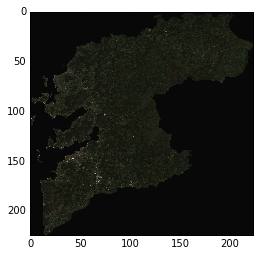

In [352]:
plt.imshow(np.stack(X[2], axis=2))

In [46]:
#X_npy = np.array(X)
#np.save("X.npy", X_npy)
#X = list(X_npy)
s = np.array(s)

In [75]:
#res = [i.split('_')[0] for i in s.split('\n')]
#np.save("file_order.npy", np.array(res))
res = list(s)
X = list(np.load("X.npy"))

In [76]:
#res = np.load("file_order.npy")
#res = list(res)
import csv

In [77]:
y_dict = {}
with open('data/nuts3.csv', mode='r') as infile:
    reader = csv.reader(infile)
    y_dict = {rows[0]:rows[15] for rows in reader}

In [84]:
y_npy = []
for name in res:
    try:
        y_npy.append(y_dict[name])
    except:
        ind = res.index(name)
        res.pop(ind)
        X.pop(ind)
        print(ind)

In [88]:
np.save("y.npy", y_npy)
y = np.array(y_npy)


In [25]:
X = np.load("X_cut.npy")
y = np.load("y.npy")
#
#np.save("X_cut.npy", np.array(X))

In [26]:
#y_npy = np.load("y.npy")
#y = np.array(y_npy).astype(int)
#X = np.load("X_cut.npy")
y = np.array([int(float(x)) for x in y])
np.max(y)


6378297

In [27]:
ylog = np.log(y)
minylog = ylog - min(ylog) + 0.0001
X = np.array(X).reshape((86, 224, 224, 3))

In [28]:
model.fit(X, ylog, epochs=30, batch_size=32)

Epoch 1/30
86/86 [==============================] - 18s 207ms/step - loss: 98.8030
Epoch 2/30
86/86 [==============================] - 1s 9ms/step - loss: 94.8459
Epoch 3/30
86/86 [==============================] - 1s 9ms/step - loss: 90.9881
Epoch 4/30
86/86 [==============================] - 1s 9ms/step - loss: 86.5987
Epoch 5/30
86/86 [==============================] - 1s 9ms/step - loss: 81.9356
Epoch 6/30
86/86 [==============================] - 1s 9ms/step - loss: 77.1933
Epoch 7/30
86/86 [==============================] - 1s 9ms/step - loss: 72.3621
Epoch 8/30
86/86 [==============================] - 1s 9ms/step - loss: 67.5041
Epoch 9/30
86/86 [==============================] - 1s 9ms/step - loss: 62.6261
Epoch 10/30
86/86 [==============================] - 1s 9ms/step - loss: 57.7258
Epoch 11/30
86/86 [==============================] - 1s 9ms/step - loss: 52.8461
Epoch 12/30
86/86 [==============================] - 1s 9ms/step - loss: 47.9414
Epoch 13/30
86/86 [===============

In [29]:
preds = model.predict(X)

In [ ]:
preds.shape

In [23]:
sum([(preds[i] - ylog[i]) ** 2 for i in range(len(preds))]) / len(preds)

array([145.0613], dtype=float32)

In [25]:
print(ylog[11:14])
np.exp(model.predict(np.array(X[11:14])))

[11.48277549 12.38895238 14.84781387]


array([[2.4089937],
       [2.4089937],
       [2.4089937]], dtype=float32)

In [ ]:
adsgsdg

In [298]:
path = '/datasets/data/earthengine/ES705_2014.tif'

In [528]:
from sklearn.preprocessing import normalize
ds = gdal.Open(path)
arr = np.nan_to_num(ds.ReadAsArray())
m = np.min(arr)
ma = np.max(arr)
arr[0] = (arr[0]) / ma
arr[1] = (arr[1]) / ma
arr[2] = (arr[2]) / ma
#arr = arr.astype('uint8')
arr[arr <= 0.333] *= 3

(3, 1655, 1767)

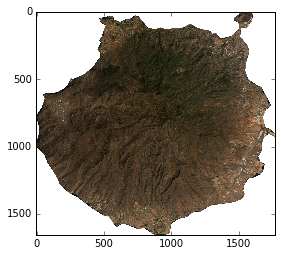

In [529]:
from skimage import data, io
arr = arr.astype('float32')
arr[arr == arr[0][0][0]] = 1.0
plt.imshow(np.stack(arr, axis=2))
arr.shape
#np.stack((arr[2], arr[1], arr[0]), axis=2).shape

In [500]:
arr

array([[[0.02187924, 0.02187924, 0.02187924, ..., 0.02187924,
         0.02187924, 0.02187924],
        [0.02187924, 0.02187924, 0.02187924, ..., 0.02187924,
         0.02187924, 0.02187924],
        [0.02187924, 0.02187924, 0.02187924, ..., 0.02187924,
         0.02187924, 0.02187924],
        ...,
        [0.02187924, 0.02187924, 0.02187924, ..., 0.02187924,
         0.02187924, 0.02187924],
        [0.02187924, 0.02187924, 0.02187924, ..., 0.02187924,
         0.02187924, 0.02187924],
        [0.02187924, 0.02187924, 0.02187924, ..., 0.02187924,
         0.02187924, 0.02187924]],

       [[0.02187924, 0.02187924, 0.02187924, ..., 0.02187924,
         0.02187924, 0.02187924],
        [0.02187924, 0.02187924, 0.02187924, ..., 0.02187924,
         0.02187924, 0.02187924],
        [0.02187924, 0.02187924, 0.02187924, ..., 0.02187924,
         0.02187924, 0.02187924],
        ...,
        [0.02187924, 0.02187924, 0.02187924, ..., 0.02187924,
         0.02187924, 0.02187924],
        [0.0

In [150]:
im = arr.astype('uint8')
print(im.shape)
img = Image.fromarray(np.stack(im, axis=2))

#img2 = image.array_t

(3, 1507, 2845)


In [151]:
img.show()

In [152]:
type(img)

PIL.Image.Image

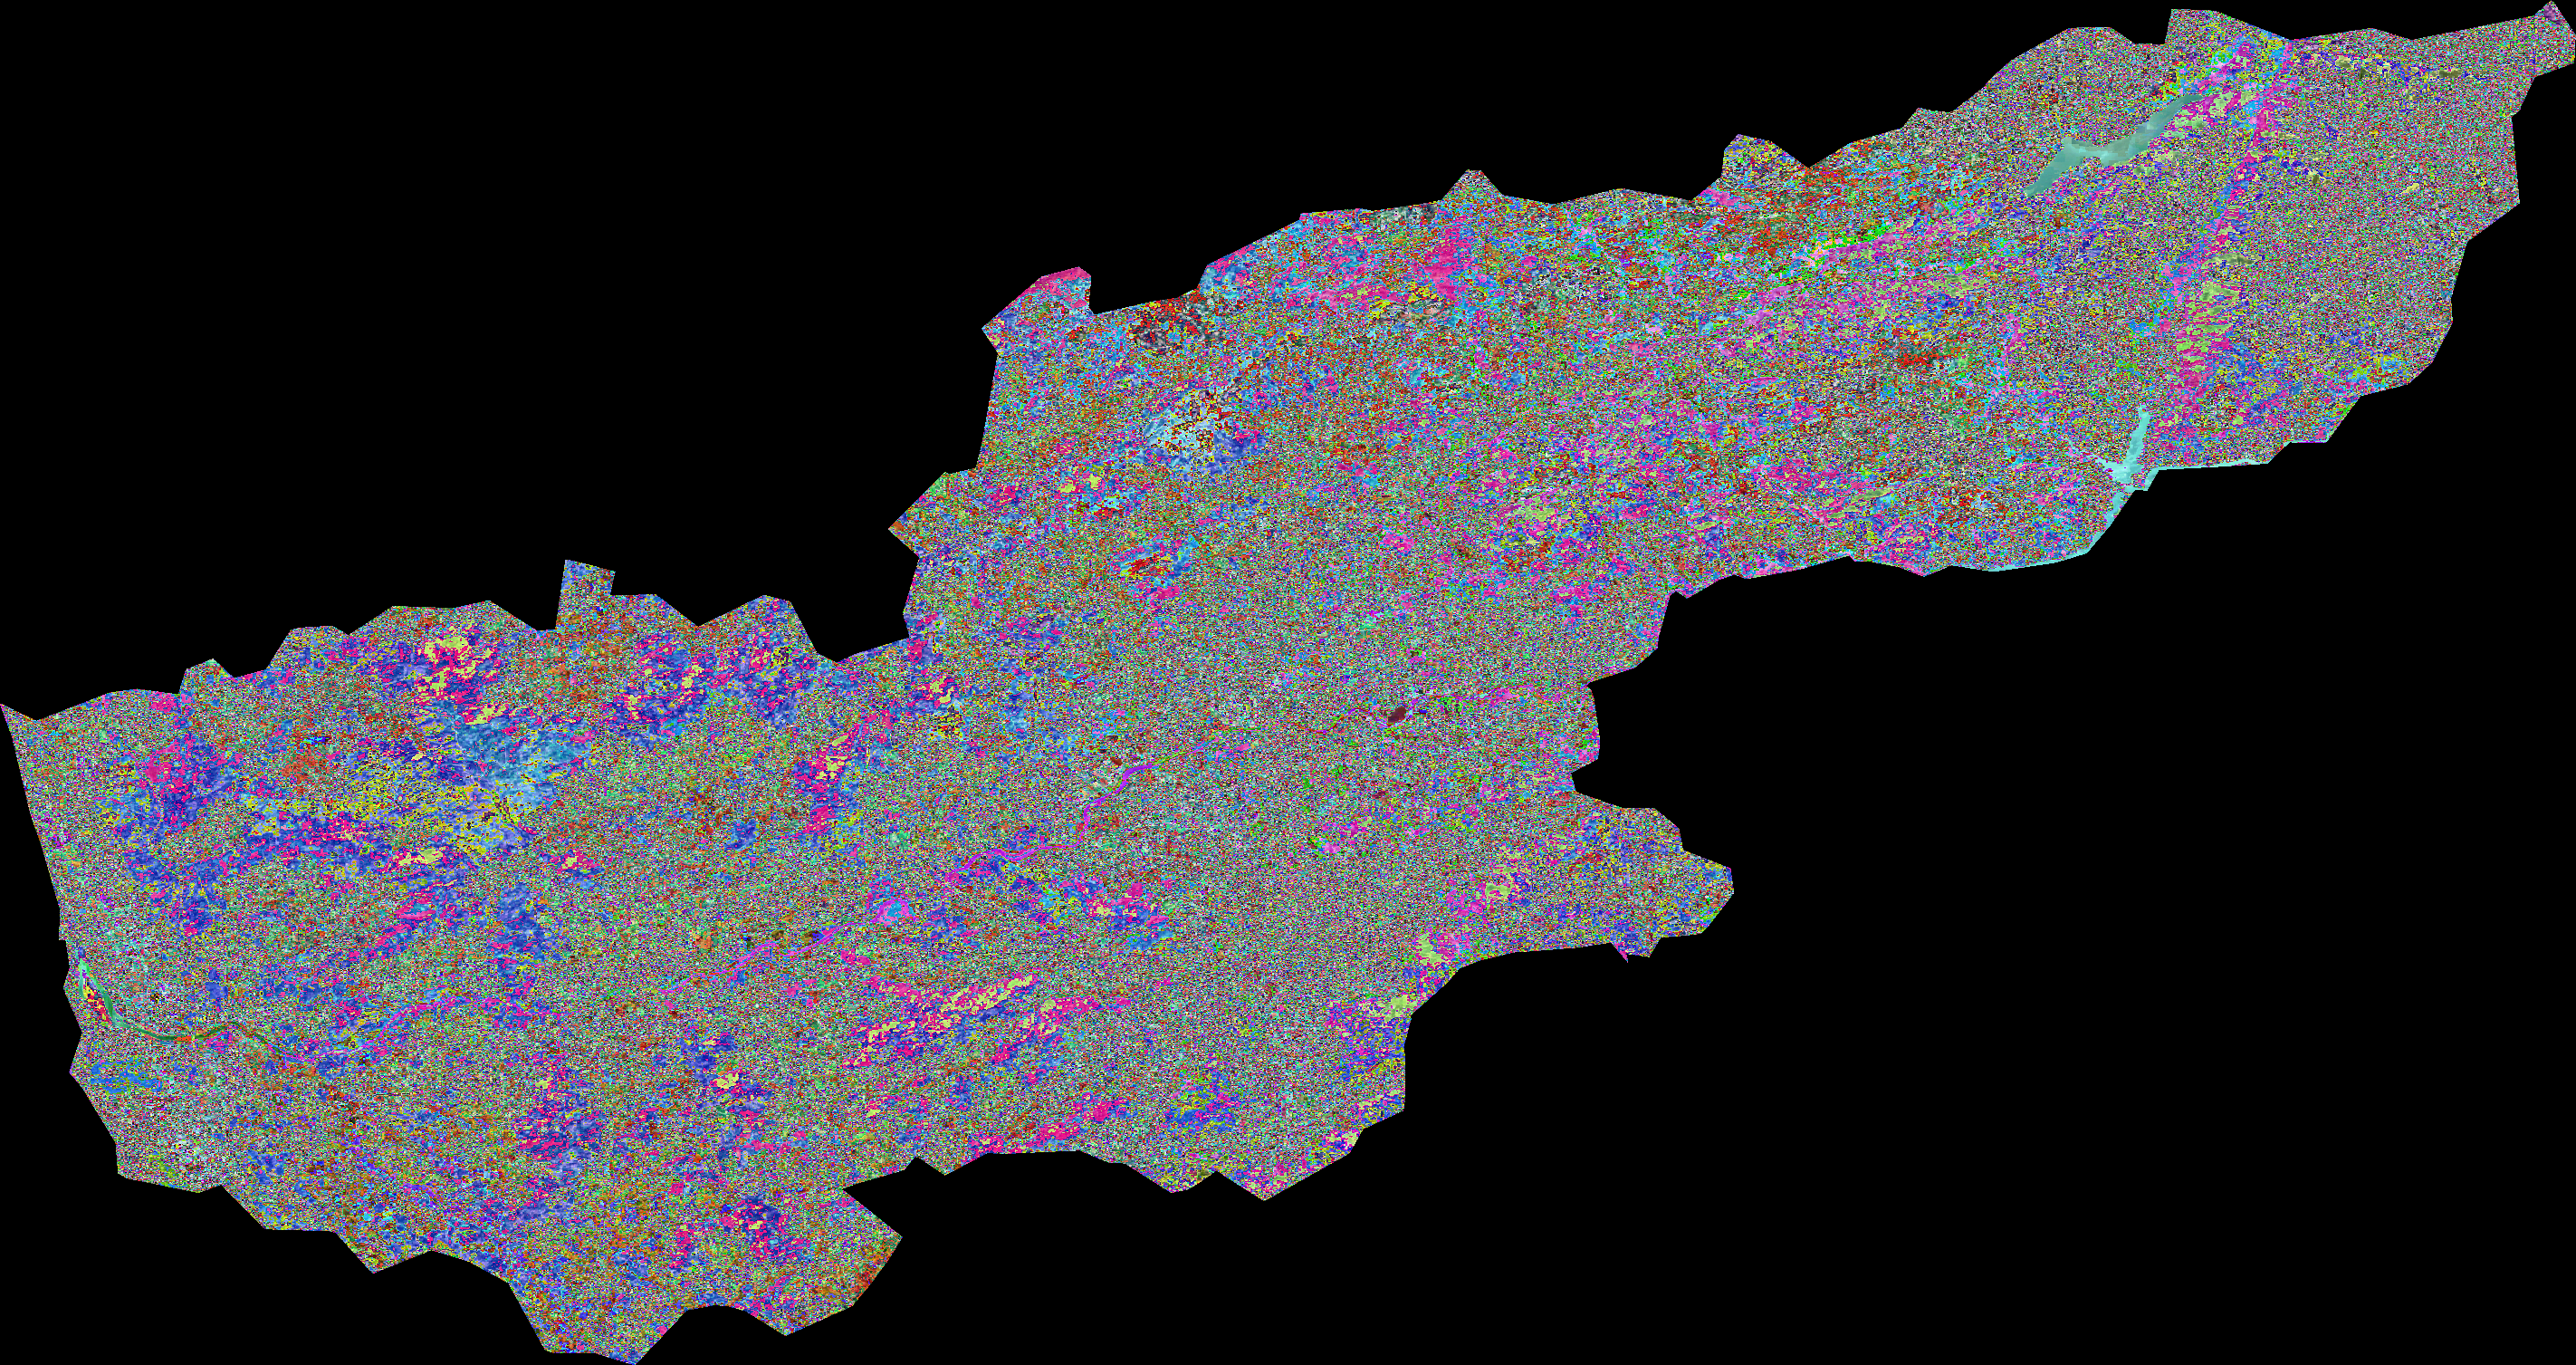

In [153]:
img